# Gene loaction prediction using Random Forest
<p >In this notebook we will use sklearn library for machine learning in python to try and predict the cluster of a gene on each chromosome and evaluate the best clustering.<br>
The clustering made oroginally in R using Pheatmap library and it's extension ComplexHeatmap which use k-means, then other clustering were made in Python using scikit-learn library for k-means and hierarchical clustering, and scikit-learn-extra for k-medoids.<br>
The notebook that shows the clustering can be found on my <a href="https://github.com/Oren93/Charr-Gene-Expression/blob/main/k-medoids-clustering.ipynb">github </a>
</p>
<p>By: Oren<br>
Faculty of natural science<br>
Biology department<br>
Háskóli Íslands - University of Iceland<br>
Sept 2021</p>
<hr>
<h2>About the data</h2>
The file 'ene-location.csv' contains the columns:
<ul>
<li>gene - scientifical name of the gene, will not be used for the model
<li>chromosome - the chromosome which the gene is on, there are 38 chromosome
<li>start - the starting point of the gene read on the chromosome
<li>end - the end point of the read
<li>cluster - cluster which the gene belongs to, by Pheatmap 
<li>length - the length of the read (deduction of start from end)
</ul>
Other features will be added later as part of the data preprocessing

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from fnmatch import fnmatch
import seaborn as sn
import pandas as pd
import numpy as np
import gene
import predict
import os

## Preparing the data
<span >First let's load the data and format it to our needs:
<ul>
    <li>The start and end location of the gene on the chromosome become a fraction location (0 to 1)</li>
    <li>The length becomes the raltive length (the whole chromosome's length is 1)</li>
    <li>Add gap length between mapped genes, and calculate the fraction length as well</li>
    <li>Add indices for genes in each chromosome, that means the index of a mapped gene on a chromosome, ignoring gaps and lengths</li>
</ul>
</span>

In [ ]:
file = "database\\genes\\gene-location.csv"
#"gene-location.csv"
df = pd.read_csv(file).rename(
    columns={'Unnamed: 0': 'index'})
df['length'] = df['end'] - df['start']
df = df.sort_values(by=['chromosome', 'start'],
                    ignore_index=True)  ## In case it isn't sorted, but I guess it is already

gene.arrange_by_index(df,newcol='fraction_index')
gene.calc_unknown_gap(df)
df = gene.gene_as_fraction(df,'start','fraction_start')
df = gene.gene_as_fraction(df,'end','fraction_end')
df = gene.gene_as_fraction(df,'length','fraction_length')
df = gene.gene_as_fraction(df, 'gap', 'fraction_gap')

In [3]:
df

,index,gene,chromosome,start,end,cluster,length,fraction_index,gap,fraction_start,fraction_end,fraction_length,fraction_gap
0,1,LOC111979261,chrLG1,145981,182797,5,36816,0.001887,145981.0,0.002520,0.003155,0.000635,0.002520
1,2,LOC111979450,chrLG1,237703,323593,4,85890,0.003774,54906.0,0.004103,0.005586,0.001483,0.000948
2,3,LOC111979522,chrLG1,334611,407222,3,72611,0.005660,11018.0,0.005776,0.007029,0.001253,0.000190
3,4,LOC111960934,chrLG1,2013575,2021316,2,7741,0.007547,1606353.0,0.034757,0.034890,0.000134,0.027728
4,5,LOC111979837,chrLG1,2039777,2044350,10,4573,0.009434,18461.0,0.035209,0.035288,0.000079,0.000319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12225,284,LOC111968953,chrLG9,31901237,31957378,8,56141,0.986111,117663.0,0.987736,0.989474,0.001738,0.003643
12226,285,LOC111968956,chrLG9,32035556,32038358,10,2802,0.989583,78178.0,0.991894,0.991981,0.000087,0.002421
12227,286,ivd,chrLG9,32204333,32214969,7,10636,0.993056,165975.0,0.997120,0.997449,0.000329,0.005139
12228,287,pomk,chrLG9,32215409,32217815,8,2406,0.996528,440.0,0.997463,0.997538,0.000074,0.000014


## Train and test
<p > Using <i>RandomForestClassifier</i> we can train and test our model. The function <i>eval_predictions</i> in the <i>predict.py</i> file is specially buily for this notebook.<br>
The function takes the data, features and target, it also takes argument <i>train_model</i> that can be 1 or 2:<br>
1 - a signle training model made by 75% of the data and test on each chromosome (subsets of testing set)<br>
2 - each chromosome has a training set for training a model and test it on the testing set of that chromosome<br>
The last parameter is percent of data to be part of the training set, the complement of that goes to the test set.
</p>
<p >Documentation for RandomForestClassifier can be found <a style="color:blue" href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">here</a></p>

<hr>
<P>Start by training and model and evaluate it's precision for 10 clusters as were chosen by Pheatmap in R rogramming language</p>

In [3]:
# eval_predictions takes a dataframe, array of feature columns, target column, and int 1 or 2 which represent:
#   1 - a signle training model made by 75% of the data and test on each chromosome (subsets of testing set)
#   2 - each chromosome has a training set for training a model and test it on the testing set of that chromosome
actual, predictions, CM = predict.eval_predictions(df, ['index', 'length'], 'cluster', train_model = 2,percent = 0.75)

0.10389684653002661
              precision    recall  f1-score   support

           1     0.0958    0.0856    0.0904       292
           2     0.0820    0.0955    0.0882       220
           3     0.0733    0.0800    0.0765       275
           4     0.0873    0.0833    0.0853       288
           5     0.0921    0.0809    0.0861       272
           6     0.0458    0.0374    0.0412       187
           7     0.0994    0.1043    0.1018       326
           8     0.1272    0.1326    0.1298       445
           9     0.1042    0.1153    0.1094       347
          10     0.1667    0.1576    0.1620       406

    accuracy                         0.1040      3058
   macro avg     0.0974    0.0973    0.0971      3058
weighted avg     0.1039    0.1040    0.1037      3058



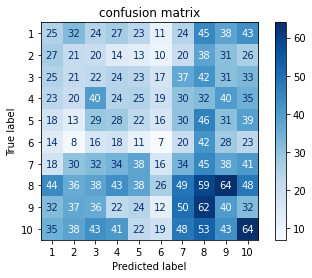

In [150]:
print(precision_score(actual, predictions , average='weighted')) # Prints the scores for each cluster
print(classification_report(actual, predictions, digits = 4)) # prints the general score
classNames = range(1,11)
disp = ConfusionMatrixDisplay(confusion_matrix=CM,display_labels=classNames)
disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.title("confusion matrix")
plt.show()

<h3 >Loading and trying many other clustered data. The creation of this data is documented in the other report.</h3>

In [5]:
path = "database\\genes\\Clusters"
main_directory = os.walk(path)
pattern = "*.csv"
files_list = []
file_names = []
for path, subdirs, files in main_directory:
    for name in files:
        if fnmatch(name, pattern):
            files_list = files_list + [os.path.join(path,name)]
            file_names = file_names + [name.split(".")[0]]

In [6]:
# add columns of different clusters
methods = ['pam','alternate','birch','pheatmap','kmeans'] # Note: pheatmap and kmeans are essentially the same, but pheatmap is made in R and kmeans in python
for method in methods:
    df = gene.add_clusters([s for s in files_list if method in s], df,method)

In [ ]:
# remove the added clusters if needed
#df = df.iloc[:, 0:13]
# print the columns
#for i in df.columns:
#    print(i)

<h2 >Prediction analytics</h2>
<p >We use the method <i>analyze</i> which is defined in <i>predict.py</i> to run tests and collect information about predictions and scores for the model for a range of number of clusters.<br>
The function <i>analyze</i> takes the data frame with the added clusters columns, features, method that was used for clustering ('pam', 'alternate','birch'...), range of clusters numbers includind both ends of the range (1 to 3 means 1,2 and 3). It optinally takes also fraction of the data to be used for training, the default is 0.75<br>
The function returns the actual values, predicted values for comparison and the confusion matrix. 
</p>
<p>The code below is very greedy, takes a few hours to run. It is good to do it once and store the values on the hard drive. What happens here is that we iterate throght different modeling approaches in order to find the most suitable features for training the model, </p>

In [ ]:
fs = [['start', 'end'],['fraction_start', 'fraction_end'],['fraction_index', 'fraction_length'],['fraction_index', 'length'], ['fraction_index', 'fraction_length','fraction_gap'], ['fraction_index'], ['fraction_index','fraction_start','fraction_length']]
methods = ['pam','alternate','birch','kmeans']
i = 1
for met in methods:
    for f in fs:
        a[i],b[i],c[i] = predict.analyze(df,features = f ,method = met,clusterRange = [2,26],percent = 0.75,iterations=5)
        a[-i],b[-i],c[-i] = predict.analyze(df,features = f ,method = met,clusterRange = [2,26],percent = 0.75,iterations=5,train_model=2)
        #plotit(a,b)
        titl = ' '.join([str(elem) for elem in f])
        d[i] = met+' '+titl
        i = i+1
# a,b,c,d are not good names for variables, they contain a lot of info to be stored and loaded using dill. 'a' is a dict of the actual values, 'b' predicted, 'c' confusion matrices, d is the indicator of keys, each key of d explaines the keys of a,b,c. example: d[12] iis 'alternate fraction_index fraction_length fraction_gap', the clustering method followed by the features used for the model

Here we compare prediction score for clustering methods:
<ul>
<li>on the x-axis are the number of clusters</li>
<li>on the y axis is the precision score</li>
<li>each line is of diffierent features that were used by the training model</li>
</ul>
<p>The plot helps to choose suitable features and clustering method for prediction</p>

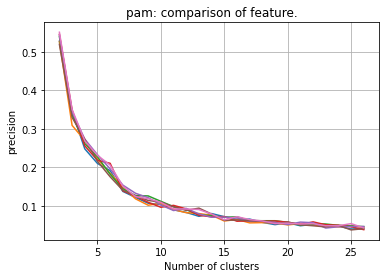

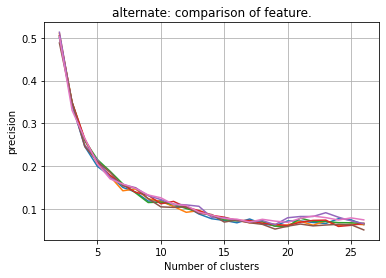

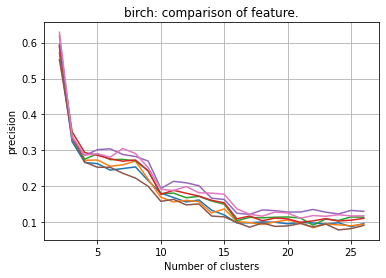

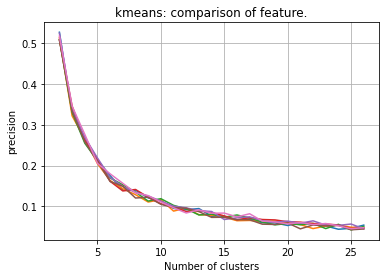

In [155]:
for i in range(4):
    # plot result of a single model
    p={key: value for key, value in b.items() if key in range(i*7+1,i*7+8)}
    v={key: value for key, value in a.items() if key in range(i*7+1,i*7+8)}
    predict.plotit(p,v,f'{methods[i]}: comparison of feature.',avg='micro',score = 'f1',multiplot=True)

From the above predictions we see that Birch (hierarchical clustering) seems to be the best clustering algorithm, however, when digging in we see that the reason it is significantly better than the others is because the distribution of clusters is very uneven and therefore the predicting algorithm can predict the most common cluster and be correct in many cases (will discuss it later). A visualization of that will be shown later.<br>
We also see that that PAM method, which according to the KMedoids documentation supposed to be more accurate actually yields worse prediction score here, the KMedoids alternate and the KMeans seems to be both quite good.<br>
Interesting to see that the prediction of clusters made by KMedoids-Alternate algorithm gets better towards 23-24 clusters, we would expect that the higher number of clusters the worse the prediction is, but it is not the case there, indicating that 23 or 24 clusters are a better bet than the range of 14-22 clusters.<br>
<p> <span style="color:red">Note:</span> The plots show the prediction made by the algorithm that uses 75% of all the data as training. The other option of making a training model for each chromosome seperately yields almost identical results and I won't include it here</p>

## Deciding on feature for the model
Assuming we want to procceed with the K-Means algorithm, we need still to decide the best data pre-processing. The options are to use the following columns as features:
<ol>
<li>'start', 'end'</li>
<li>'fraction_start', 'fraction_end'</li>
<li>'fraction_index', 'fraction_length'</li>
<li>'fraction_index', 'length'</li>
<li>'fraction_index', 'fraction_length','fraction_gap'</li>
<li>'fraction_index' (tested mainly for curiosity purposes and comparison with the others)</li>
<li>'fraction_index','fraction_start','fraction_length'</li>
</ol>

In [158]:
print('Print the precision scores for each model')
di = {}
for i in v.keys():
    x = []
    for j in range(2,26):
        x = x +[precision_score(v[i][j], p[i][j], labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')]
    di[i] = x
j = 22
for i in di.keys():
    print(np.average(di[i]),end=': ')
    print(d[j])
    j = j + 1

Print the precision scores for each model
0.1262807935469806: kmeans start end
0.12333769348157837: kmeans fraction_start fraction_end
0.1254768912143013: kmeans fraction_index fraction_length
0.12732995421844343: kmeans fraction_index length
0.1296462829736211: kmeans fraction_index fraction_length fraction_gap
0.12301068236320035: kmeans fraction_index
0.12936014824504036: kmeans fraction_index fraction_start fraction_length


As expected, the best features to be used are <i>fraction_index, fraction_length and fraction_gap</i>, makes sense when considering the bilogical meaning of these features.<br>
<p> <span style="color:red">reminder:</span> The <i>fraction</i> keyword indicates that the data is mapped to [0,1] interval for each chromosome. Example: If there are 100 mapped genes on some chromosome, they are counted by indices 1-100 and fraction index is the index divided by 100</p>
<hr>
Another interesting approach is to train a model where the training set consists of all the chromosomes except one and then try and predict the one chromosome. By the biological assumptions that the chromosomes aren't related and shouldn't affect each other, this is expected to yield quite random results

In [39]:
features = ['fraction_index', 'fraction_length', 'fraction_gap']
csV_km,csP_km,csCM_km = predict.predict2(df,'kmeans',features =features,clusterRange = [2,26])
#csV_b,csP_b,csCM_b = predict.predict2(df,'birch',features =features,clusterRange = [2,26])
#csV_pam,csP_pam,csCM_pam = predict.predict2(df,'pam',features =features,clusterRange = [2,26])
#csV_alt,csP_alt,csCM_alt = predict.predict2(df,'alternate',features =features,clusterRange = [2,26])


In [159]:
p = {1: b[26], 2: csP_km}
v = {1: a[26], 2: csV_km}

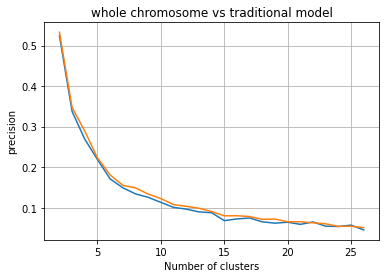

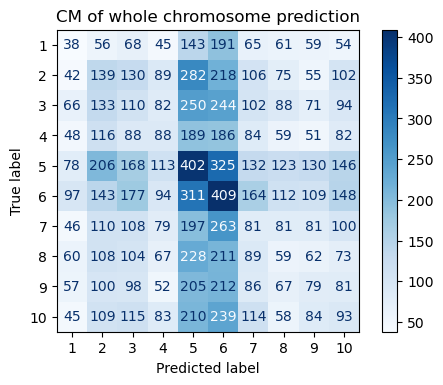

In [162]:
#predict.plotit(csV_km,csP_km,title='precision of a whole chromosome prediction',avg='micro',score = 'precision',multiplot=False,colour='b')
predict.plotit(p,v,'whole chromosome vs traditional model',avg='micro',score = 'precision',multiplot=True)
#predict.plotit(csV_b,csP_b,title='comparison',avg='micro',score = 'precision',multiplot=False,colour='r')
#predict.plotit(csV_pam,csP_pam,title='comparison',avg='micro',score = 'precision',multiplot=False,colour='c')
#predict.plotit(csV_alt,csP_alt,title='comparison',avg='micro',score = 'precision',multiplot=False,colour='y')
predict.plotCM(csCM_km[10],title='CM of whole chromosome prediction',fontSize=10,dpi=100)

Although the chromosomes are supposed to have have no influence on each other, it seems that the precision is slightly better when predicting a whole chromosome based on the others, however the difference is very small.
<hr><br>
Now a very interesting approach, for each chromosome the model is trained base on all genes except on, then try to predict the one gene's cluster. It iterates throgh all the chromosomes, all the genes and all the clustering of K-means from 2 to 26 clusters. This method is called in short 'leave one out'. Takes a long time to compute, values can be extracted using dill in the end of the notebook


In [70]:
features = ['fraction_index', 'fraction_length', 'fraction_gap']
p3V_km,p3P_km,p3CM_km = predict.predict3(df,'kmeans',features =features,clusterRange = [2,26])

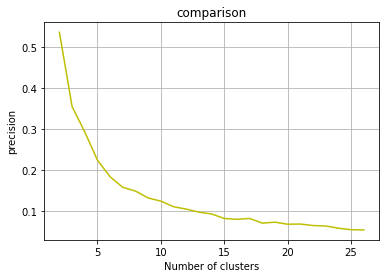

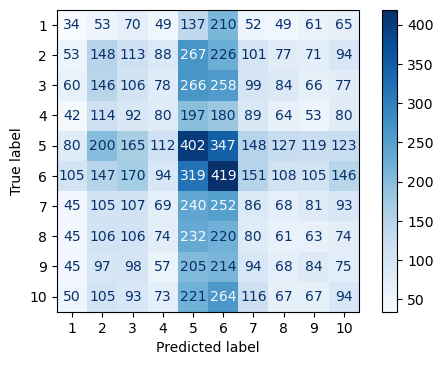

In [96]:
predict.plotit(p3V_km,p3P_km,title='comparison',avg='micro',score = 'f1',multiplot=False,colour='y')
predict.plotCM(p3CM_km[10],'',fontSize=10,dpi=100)


In [72]:
# Saving the variable, it took 2 and a half days to compute them
file = 'forest_variable_LOO_env.db'
with open(file,"wb") as f:
    dill.dump([p3V_km,p3P_km,p3CM_km], f)

The Leave one out model uses almost all the data for training and is expected to yield a n accurate result, but this isn't the case, that supports the idea that the clustering is very random. To base this conclusion we need to produce random clustering and try to predict it, or alternatively compare the existing clustering  (as actual value) to random clustering (as "predicted" values) and check the scores.

Precision score for random predicted data: 0.10261894137131398


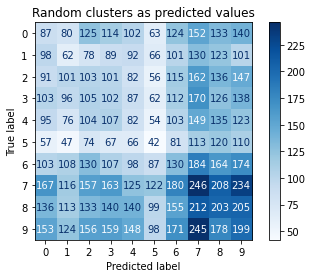

In [163]:
import random as rand
from collections import Counter
clusters = Counter(df['cluster'])

weights = [clusters[i]/len(df) for i in range(1,11)]
mock2 = rand.choices([1,2,3,4,5,6,7,8,9,10],weights=weights,k=len(df))

print('Precision score for random predicted data',precision_score(df[['cluster']], mock2 , average='weighted'),sep=': ')

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df[['cluster']], mock2))
disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.title("Random clusters as predicted values")
plt.show()


Let's add columns 24 columns of random-clusters to a copy of the dataset table, from 2 clusters to 24, and try and predict it, just as before.

In [91]:
f = ['fraction_index', 'fraction_length', 'fraction_gap']
df_Rand = df.copy().loc[:,['gene','chromosome','fraction_index', 'fraction_length', 'fraction_gap']]
for i in range(2,27):
    j = i
    if i<10:
        j = f'0{i}'
    df_Rand[f'cluster_{j}_Rand'] = rand.choices([k for k in range(1,i+1)],k=len(df))
randV_km,randP_km,randCM_km = predict.analyze(df_Rand,features = f ,method = 'Rand',clusterRange = [2,26],percent = 0.75,iterations=5,train_model=2)

|                         |100%
|-------------------------|


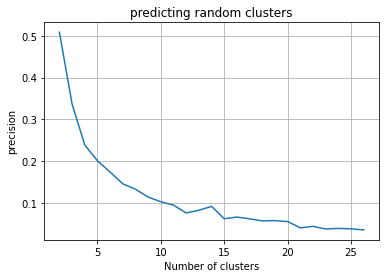

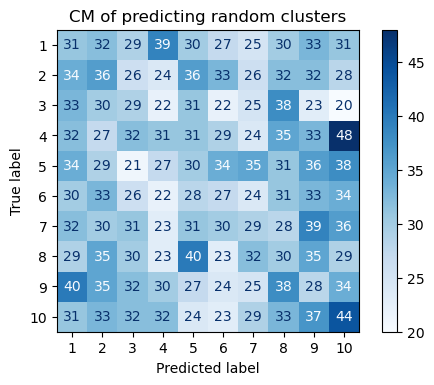

In [166]:
predict.plotit(randP_km,randV_km,title='predicting random clusters',avg='micro',score = 'precision',multiplot=False)
predict.plotCM(randCM_km[10],title='CM of predicting random clusters',fontSize=10,dpi=100)

# Conclusion:
 The graph shows similar precision score for random clustering and k-means clustering. But the confusion matrix for 10 clusters indicates that the clustering does have some sense in the chaos, it is not completely random. The prediction is almost as good as random, yet slightly better, that is something worth checking in term of genetics of the genes that form the clusters.

## P.S
The reason the idea of using hierarchical clustering was abandoned is due to it's uneven cluster sizes as can be seem in the plot below:

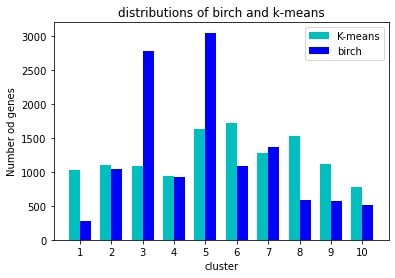

In [141]:
labels = np.array([i for i in range(1,11)])

xaxis = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
x = list(Counter(df['cluster']).values())
rects1 = ax.bar(labels-1 - width/2, x, width,color='c', label='K-means')
x = list(Counter(df['cluster_10_birch']).values())
rects2 = ax.bar(labels-1 + width/2, x, width,color='b', label='birch')
ax.set_ylabel('Number od genes')
ax.set_xlabel('cluster')
ax.set_title('distributions of birch and k-means')
ax.set_xticks(labels-1)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Since the clusters sizes differ so much, then the learning algorithm is biased, meaning it would usually bet on cluster 3 and 5 and will usually be correct.

<hr>
<p>Like in the previous report, also here the files containing the variables and the datasets won't get included as for now. There is no permission to publish it yet.</p>

In [10]:
#save the variables that took long computation time
file = 'forest_variable_env.db'
import dill
import pickle
#with open(file,"wb") as f:
#    dill.dump_session(f)
with open(file,"wb") as f:
    dill.dump([a,b,c,d], f)

In [153]:
# load the variables that we saved
import dill
import pickle
file = 'forest_variable_env.db'

with open(file,"rb") as f:
    dil=dill.load(f)
a,b,c,d = dil[0],dil[1],dil[2],dil[3]

In [ ]:
# Loading the variables of leave one out model
file = 'forest_variable_LOO_env.db'
with open(file,"rb") as f:
    dil=dill.load(f)
p3V_km,p3P_km,p3CM_km = dil[0],dil[1],dil[2]